# __[ LG Energy Solution ] <br><br>Anomaly Detection Part2: LOF, iForest, AE__

# <br>__1. Data: NASA Bearing Dataset__

- 데이터 description <br>
    - NASA Bearing Dataset은 NSF I/UCR Center의 Intelligent Maintenance System의 4개의 bearing에서 고장이 발생할 때까지 10분 단위로 수집된 센서 데이터이다. 본 데이터셋은 특정 구간에서 기록된 1-second vibration signal snapshots을 나타내는 여러 개의 파일로 구성되어 있다. 각 파일은 20 kHz 단위로 샘플링 된 20,480개의 data point를 포함하고 있으며, 각 파일의 이름은 데이터가 수집된 시간을 의미한다. 해당 데이터셋은 크게 3개의 데이터를 포함하고 있으며, 본 실습에서 사용하는 데이터는 bearing 1에서 outer race failure가 발생할 때까지 수집된 센서 데이터이다. <br><br>
- 변수
    - 센서 데이터: Bearing1, Bearing2, Bearing3, Bearing4 <br><br>
- 출처: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/


<img src="https://i.imgur.com/dfFzn3H.jpg" width="600">

In [ ]:
# github에서 데이터 불러오기
!git clone https://github.com/hj-choi-95/Anomaly_Detection_Part2.git

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### Step1. 데이터 불러오기

In [2]:
# 데이터 불러오기
data = pd.read_csv('/content/Anomaly_Detection_Part2/data/nasa_bearing_dataset.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4,anomaly,data_type
2004-02-12 10:32:39,0.058332,0.071832,0.083244,0.043065,0,train
2004-02-12 10:42:39,0.058997,0.074008,0.084439,0.044540,0,train
2004-02-12 10:52:39,0.060239,0.074223,0.083922,0.044442,0,train
2004-02-12 11:02:39,0.061453,0.073843,0.084462,0.045081,0,train
2004-02-12 11:12:39,0.061361,0.075606,0.082837,0.045118,0,train


### Step2. 데이터 Split

In [3]:
X_train = data[data['data_type'] == 'train'].iloc[:, :4]

X_test = data[data['data_type'] == 'test'].iloc[:, :4]
y_test = data[data['data_type'] == 'test'].iloc[:, -2].values

In [4]:
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.6, random_state=42)

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_valid.shape)
print("Test data shape:", X_test.shape)

Training data shape: (492, 4)
Validation data shape: (196, 4)
Test data shape: (296, 4)


---

# __<br> 2. Local Oulier Factor__

### Local Outlier Factor (LOF)
>이상치 스코어를 산출할 떄 주변부 데이터의 밀도를 고려하고자 함

<img src="https://i.imgur.com/flXG1jT.jpg" width="450">

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, roc_curve, auc

### Step 0. 데이터 정규화

In [6]:
# train 데이터를 기반으로 train/test 데이터에 대하여 standard scaling 적용 (평균 0, 분산 1) 
scaler = StandardScaler()
scaler = scaler.fit(X_train)

In [7]:
lof_X_train = pd.DataFrame(scaler.transform(X_train), 
                           columns=X_train.columns, index=X_train.index)
lof_X_valid = pd.DataFrame(scaler.transform(X_valid), 
                           columns=X_valid.columns, index=X_valid.index)
lof_X_test = pd.DataFrame(scaler.transform(X_test), 
                          columns=X_test.columns, index=X_test.index)

### Step 1. Train 데이터 기반 모델 적합

- LocalOutlierFactor 설명
    - n_neighbors: neighbors 개수. 디폴트 20
    - algorithm: nearest neighbors 계산 방법 ('auto', 'ball_tree', 'kd_tree', 'brute'}. 디폴트 'auto'
    - metric: distance 계산 방법. 디폴트 'minkowski'
    - novelty: True (for novelty detection - no oulier in train data), False (for outlier detection - ouliers in train data). 디폴트 False

In [8]:
# LOF 모델 적합
lof_model = LocalOutlierFactor(n_neighbors=5, novelty=True)
lof_model.fit(lof_X_train)

LocalOutlierFactor(n_neighbors=5, novelty=True)

### Step 2. 적합된 모델을 기반으로 train/test 데이터의 anomaly score 도출

In [9]:
# train/validation/test 데이터의 LOF score 도출
lof_train = - 1.0 * lof_model.score_samples(lof_X_train)
lof_valid = - 1.0 * lof_model.score_samples(lof_X_valid)
lof_test = - 1.0 * lof_model.score_samples(lof_X_test)

/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

Text(0.5, 1.0, 'Test Data')

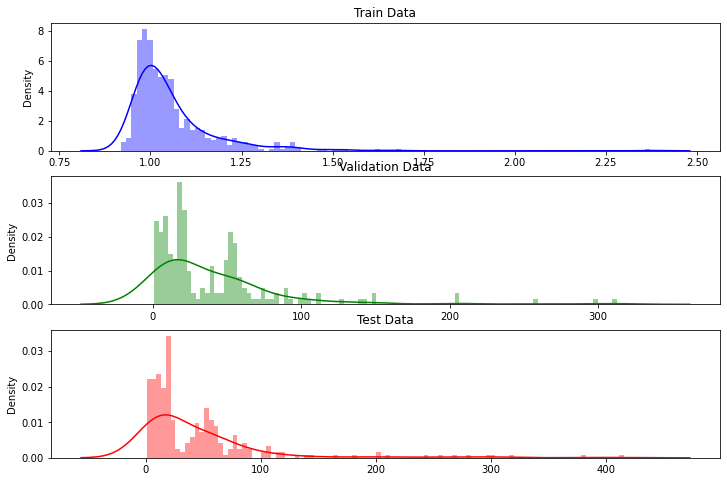

In [10]:
# train/validation/test 데이터의 anomaly score 분포 시각화
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize = (12, 8))

sns.distplot(lof_train, bins=100, kde=True, color='blue', ax=ax1)
sns.distplot(lof_valid, bins=100, kde=True, color='green', ax=ax2)
sns.distplot(lof_test, bins=100, kde=True, color='red', ax=ax3)
ax1.set_title("Train Data")
ax2.set_title("Validation Data")
ax3.set_title("Test Data")

### Step 3. Threshold 탐색

In [11]:
# threshold 탐색
# score의 min ~ max 범위를 num_step개로 균등 분할한 threshold에 대하여 best threshold 탐색 
def search_best_threshold(score, y_true, num_step):
    best_f1 = 0
    best_threshold = None
    for threshold in np.linspace(min(score), max(score), num_step):
        y_pred = threshold < score

        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    print('Best threshold: ', round(best_threshold, 4))
    print('Best F1 Score:', round(best_f1, 4))
    return best_threshold

In [12]:
# best threshold 도출
lof_best_threshold = search_best_threshold(lof_valid, y_valid, num_step=1000)

Best threshold:  15.0301
Best F1 Score: 0.9266


### Step 4. Best threshold를 기반으로 이상치 탐지 모형 평가

In [13]:
# 최종 결과 도출
lof_scores = pd.DataFrame(columns=['score', 'anomaly'])
for date, score in zip([X_train.index, X_valid.index, X_test.index], [lof_train, lof_valid, lof_test]):
    lof_score = pd.DataFrame(index=date)
    lof_score['score'] = score
    lof_score['anomaly'] = lof_best_threshold < score
    lof_scores = lof_scores.append(lof_score)

In [14]:
lof_scores.head()

,score,anomaly
2004-02-12 10:32:39,2.371053,False
2004-02-12 10:42:39,1.674762,False
2004-02-12 10:52:39,1.250015,False
2004-02-12 11:02:39,1.218462,False
2004-02-12 11:12:39,1.347574,False


In [15]:
# anomaly score plot 도출
def draw_plot(scores, threshold):
    normal_scores = scores[scores['anomaly'] == False]
    abnormal_scores = scores[scores['anomaly'] == True]

    plt.figure(figsize = (12,5))
    plt.scatter(normal_scores.index, normal_scores['score'], label='Normal', c='blue', s=3)
    plt.scatter(abnormal_scores.index, abnormal_scores['score'], label='Abnormal', c='red', s=3)
    
    plt.axhline(threshold, c='green', alpha=0.7)
    plt.axvline(data.index[int(len(data) * 0.5)], c='orange', ls='--')
    plt.axvline(data.index[int(len(data) * 0.7)], c='orange', ls='--')
    
    plt.xlabel('Date')
    plt.ylabel('Anomaly Score')
    plt.legend()
    
    plt.show()

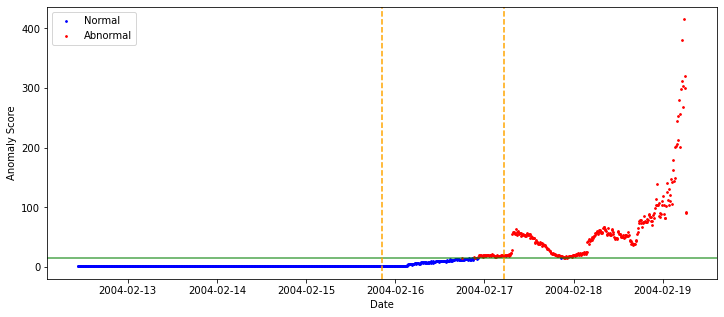

In [16]:
# 전체 데이터의 anomaly score 확인
draw_plot(lof_scores, lof_best_threshold)

In [17]:
# FRR, FAR, F1 score 도출
def calculate_metric(y_true, y_pred):
    # FRR, FAR
    cm = confusion_matrix(y_true, y_pred, labels=[True, False])
    tp, fn, fp, tn = cm.ravel()
    frr = fp / (fp + tn)
    far = fn / (fn + tp) 
    
    # F1 Score
    f1 = f1_score(y_true, y_pred)
    
    # AUROC, IE
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    auroc = auc(fpr, tpr)
    ie = 1 - auroc
    
    return frr, far, f1, auroc, ie

In [18]:
# F1 Score: 0.9309
frr, far, f1, auroc, ie = calculate_metric(y_test, lof_best_threshold < lof_test)

print("**  FRR: {}  |  FAR: {}  |  F1 Score: {}  |  AUROC: {}  |  IE: {}"
      .format(round(frr, 4), round(far, 4), round(f1, 4), round(auroc, 4), round(ie, 4)))

**  FRR: 0.2083  |  FAR: 0.0057  |  F1 Score: 0.9309  |  AUROC: 0.893  |  IE: 0.107


# __<br>3. Isolation Forest__

### Isolation Forest
>하나의 객체를 고립시키는 의사결정나무를 생성하여 이상치를 탐지하고자 함 <br>
>정상 데이터는 고립시키는데 많은 분기가 필요하지만, 이상치 데이터라면 상대적으로 적은 분기만으로 고립이 가능함

<img src="https://i.imgur.com/VVbACBB.jpg" width="700">

In [19]:
from sklearn.ensemble import IsolationForest

### Step 1. Train 데이터 기반 모델 적합

- IsolationForest 설명
    - n_estimators: 트리 개수. 디폴트 100
    - bootstrap: 데이터의 중복 사용 여부. 디폴트 False
    - max_samples: 데이터 샘플 중 선택할 샘플의 수 혹은 비율 ('auto': max_samples=min(256, n_samples)) . 디폴트 'auto'

In [20]:
if_model = IsolationForest(random_state=42)
if_model.fit(X_train)

IsolationForest(random_state=42)

### Step 2. 적합된 모델을 기반으로 train/test 데이터의 anomaly score 도출

In [21]:
# train/validation/test 데이터의 IF score 도출
if_train = - 1.0 * if_model.score_samples(X_train)
if_valid = - 1.0 * if_model.score_samples(X_valid)
if_test = - 1.0 * if_model.score_samples(X_test)

/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

Text(0.5, 1.0, 'Test Data')

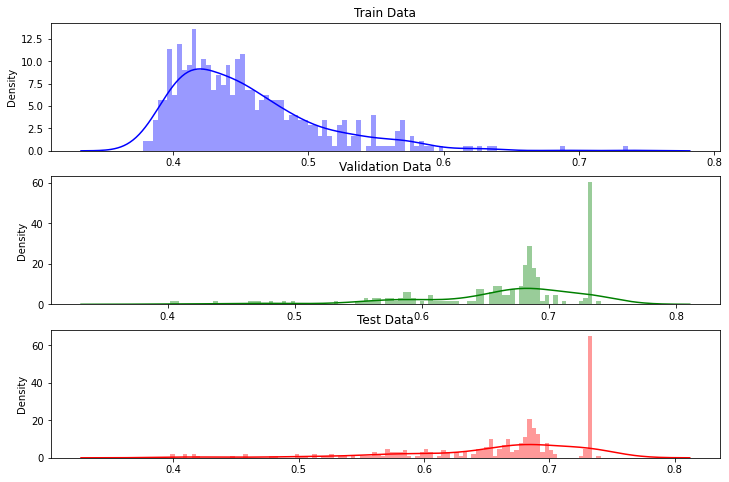

In [22]:
# train/validation/test 데이터의 anomaly score 분포 시각화
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize = (12, 8))

sns.distplot(if_train, bins=100, kde=True, color='blue', ax=ax1)
sns.distplot(if_valid, bins=100, kde=True, color='green', ax=ax2)
sns.distplot(if_test, bins=100, kde=True, color='red', ax=ax3)
ax1.set_title("Train Data")
ax2.set_title("Validation Data")
ax3.set_title("Test Data")

### Step 3. Threshold 탐색

In [23]:
# best threshold 도출
if_best_threshold = search_best_threshold(if_valid, y_valid, num_step=1000)

Best threshold:  0.6722
Best F1 Score: 0.9483


### Step 4. Best threshold를 기반으로 이상치 탐지 모형 평가

In [24]:
# 최종 결과 도출
if_scores = pd.DataFrame(columns=['score', 'anomaly'])
for date, score in zip([X_train.index, X_valid.index, X_test.index], [if_train, if_valid, if_test]):
    if_score = pd.DataFrame(index=date)
    if_score['score'] = score
    if_score['anomaly'] = if_best_threshold < score
    if_scores = if_scores.append(if_score)

In [25]:
if_scores.head()

,score,anomaly
2004-02-12 10:32:39,0.735772,True
2004-02-12 10:42:39,0.635403,False
2004-02-12 10:52:39,0.566701,False
2004-02-12 11:02:39,0.635642,False
2004-02-12 11:12:39,0.548939,False


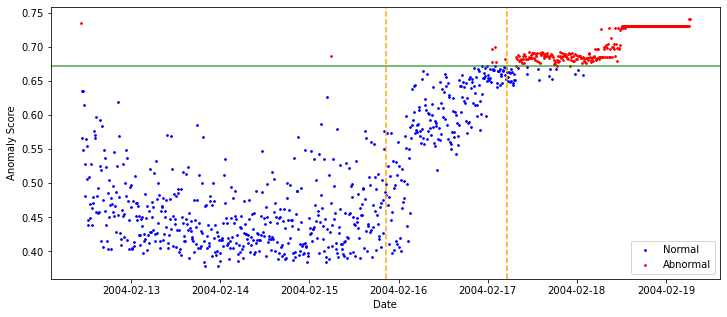

In [26]:
# 전체 데이터의 anomaly score 확인
draw_plot(if_scores, if_best_threshold)

In [27]:
# F1 Score: 0.944
frr, far, f1, auroc, ie = calculate_metric(y_test, if_best_threshold < if_test)

print("**  FRR: {}  |  FAR: {}  |  F1 Score: {}  |  AUROC: {}  |  IE: {}"
      .format(round(frr, 4), round(far, 4), round(f1, 4), round(auroc, 4), round(ie, 4)))

**  FRR: 0.025  |  FAR: 0.0909  |  F1 Score: 0.944  |  AUROC: 0.942  |  IE: 0.058


---

# __4. Auto-Encoder__

### Auto-Encoder (Auto-Associative Neural Network)
>입력과 출력이 동일한 인공신경망 구조 <br>
>정상 데이터에 대한 학습이 충분히 되어 있을 경우 정상 데이터는 자기 자신을 잘 복원할 수 있지만, 이상치 제이터는 학습 기회가 적어 상대적으로 잘 복원하지 못할 것을 가정

<img src="https://i.imgur.com/DTgug9o.jpg" width="700">

In [28]:
import copy
import random
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [29]:
# hyper-parameter 설정
input_size = 4
hidden_size = 2

num_epochs = 500
batch_size = 32
learning_rate = 0.0001

random_seed = 42
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Detect if we have a GPU available

In [30]:
# seed 고정
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

### Step0. 데이터 정규화

In [31]:
# train 데이터를 기반으로 train/test 데이터에 대하여 min-max scaling 적용 
scaler = MinMaxScaler()
scaler = scaler.fit(X_train)

In [32]:
ae_X_train = scaler.transform(X_train)
ae_X_valid = scaler.transform(X_valid)
ae_X_test = scaler.transform(X_test)

### Step 1. DataLoader 만들기 (Custom dataset)

In [33]:
class AE_CustomDataset(Dataset): 
    def __init__(self, data):
        self.data = data

    # 총 데이터의 개수를 리턴
    def __len__(self): 
        return len(self.data)

    # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
    def __getitem__(self, idx): 
        x = torch.FloatTensor(self.data[idx])
        return x

In [34]:
ae_train_dataset = AE_CustomDataset(ae_X_train)
ae_train_loader = DataLoader(ae_train_dataset, batch_size=batch_size, shuffle=True)

ae_test_dataset = AE_CustomDataset(ae_X_test)
ae_test_loader = DataLoader(ae_test_dataset, batch_size=batch_size, shuffle=False)

In [35]:
# validation dataloader의 경우 train/test 단계에서 사용될 loader를 따로 생성함
# train 단계: 정상으로만 구성, test 단계: 정상과 비정상으로 구성
ae_valid_test_dataset = AE_CustomDataset(ae_X_valid)
ae_valid_test_loader = DataLoader(ae_valid_test_dataset, batch_size=batch_size, shuffle=False)

ae_X_valid_train = ae_X_valid[y_valid == 0]
ae_valid_train_dataset = AE_CustomDataset(ae_X_valid_train)
ae_valid_train_loader = DataLoader(ae_valid_train_dataset, batch_size=batch_size, shuffle=False)

### Step 2. 모델 구축

In [36]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
          nn.Linear(input_size, hidden_size),
          nn.ReLU()
        )
        self.decoder = nn.Sequential(
          nn.Linear(hidden_size, input_size)
        )
        
    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        out = torch.sigmoid(out)
        return out

In [37]:
ae_model = AutoEncoder(input_size, hidden_size)

In [38]:
ae_model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=2, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
  )
)

### Step 3. Train 데이터로 모델 학습

In [39]:
# model 학습
def train_model(dataloaders, model, criterion, num_epochs, learning_rate, device):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_valid_loss = 10000000

    for epoch in range(num_epochs):
        if epoch == 0 or (epoch + 1) % 50 == 0:
            print()
            print('Epoch {}/{}'.format(epoch + 1, num_epochs))

        # 각 epoch마다 순서대로 training과 validation을 진행
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 training mode로 설정
            else:
                model.eval()   # 모델을 validation mode로 설정

            running_loss = 0.0
            running_total = 0

            # training과 validation 단계에 맞는 dataloader에 대하여 학습/검증 진행
            for i, inputs in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)

                # parameter gradients를 0으로 설정
                optimizer.zero_grad()

                # forward
                # training 단계에서만 gradient 업데이트 수행
                with torch.set_grad_enabled(phase == 'train'):
                    # input을 model에 넣어 output을 도출한 후, loss를 계산함
                    outputs = model(inputs)
                    loss = criterion(outputs, inputs)

                    # backward (optimize): training 단계에서만 수행
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # batch별 loss를 축적함
                running_loss += loss.item() * inputs.size(0)
                running_total += inputs.size(0)

            # epoch의 loss 및 accuracy 도출
            epoch_loss = running_loss / running_total

            if epoch == 0 or (epoch + 1) % 50 == 0:
                print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # validation 단계에서 validation loss가 감소할 때마다 best model 가중치를 업데이트함
            if phase == 'val' and epoch_loss < best_valid_loss:
                best_valid_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

    # validation loss가 가장 낮았을 때의 best model 가중치를 불러와 best model을 구축함
    print('Best validation loss: {:4f}'.format(best_valid_loss))
    model.load_state_dict(best_model_wts)
    return model

In [40]:
ae_dataloaders = {'train': ae_train_loader, 'val': ae_valid_train_loader}
ae_train_criterion = nn.MSELoss()
ae_model = train_model(ae_dataloaders, ae_model, ae_train_criterion, num_epochs, learning_rate, device)


Epoch 1/500
train Loss: 0.0437
val Loss: 1.4628

Epoch 50/500
train Loss: 0.0348
val Loss: 1.5112

Epoch 100/500
train Loss: 0.0312
val Loss: 1.5240

Epoch 150/500
train Loss: 0.0296
val Loss: 1.5163

Epoch 200/500
train Loss: 0.0287
val Loss: 1.4969

Epoch 250/500
train Loss: 0.0281
val Loss: 1.4721

Epoch 300/500
train Loss: 0.0275
val Loss: 1.4467

Epoch 350/500
train Loss: 0.0270
val Loss: 1.4239

Epoch 400/500
train Loss: 0.0264
val Loss: 1.4034

Epoch 450/500
train Loss: 0.0257
val Loss: 1.3851

Epoch 500/500
train Loss: 0.0251
val Loss: 1.3700
Best validation loss: 1.369999


### Step 4. 적합된 모델을 기반으로 train/test 데이터의 anomaly score 도출 (Inference)

In [41]:
# model inference
def inference_model(data_loader, model, criterion, device):
    model = model.to(device)
    
    model.eval()
    with torch.no_grad():
        infer_loss = []
        for i, x in enumerate(data_loader):
            x = x.to(device)
            
            # Forward pass
            output = model(x)
            loss = criterion(output, x)
            loss = loss.reshape(loss.shape[0], -1).mean(axis=1)

            infer_loss += list(loss.data.cpu().numpy())
    return infer_loss

In [42]:
# train/validation/test 데이터에 대한 최종 결과 도출
ae_infer_criterion = nn.L1Loss(reduction='none')
ae_train = inference_model(ae_train_loader, ae_model, ae_infer_criterion, device)
ae_valid = inference_model(ae_valid_test_loader, ae_model, ae_infer_criterion, device)
ae_test = inference_model(ae_test_loader, ae_model, ae_infer_criterion, device)

/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

Text(0.5, 1.0, 'Test Data')

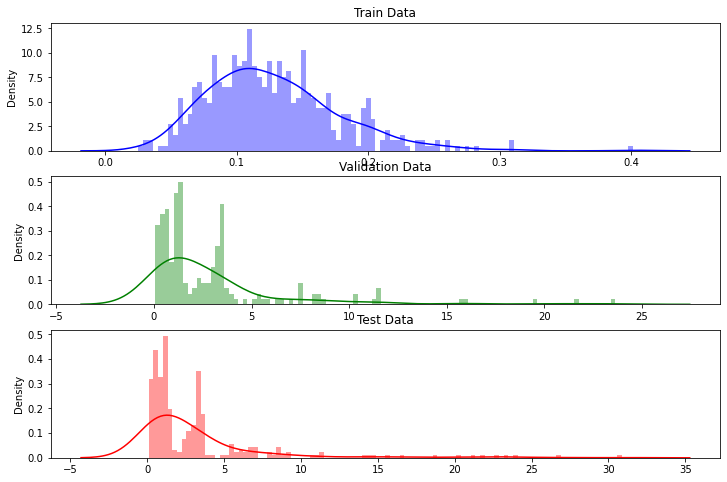

In [43]:
# train/validation/test 데이터의 anomaly score 분포 시각화
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize = (12, 8))

sns.distplot(ae_train, bins=100, kde=True, color='blue', ax=ax1)
sns.distplot(ae_valid, bins=100, kde=True, color='green', ax=ax2)
sns.distplot(ae_test, bins=100, kde=True, color='red', ax=ax3)
ax1.set_title("Train Data")
ax2.set_title("Validation Data")
ax3.set_title("Test Data")

### Step 5. Threshold 탐색

In [44]:
# best threshold 도출
ae_best_threshold = search_best_threshold(ae_valid, y_valid, num_step=1000)

Best threshold:  1.1832
Best F1 Score: 0.935


### Step 6. Best threshold를 기반으로 이상치 탐지 모형 평가

In [45]:
# 최종 결과 도출
ae_scores = pd.DataFrame(columns=['score', 'anomaly'])
for date, score in zip([X_train.index, X_valid.index, X_test.index], [ae_train, ae_valid, ae_test]):
    ae_score = pd.DataFrame(index=date)
    ae_score['score'] = score
    ae_score['anomaly'] = ae_best_threshold < score
    ae_scores = ae_scores.append(ae_score)

In [46]:
ae_scores.head()

,score,anomaly
2004-02-12 10:32:39,0.148910,False
2004-02-12 10:42:39,0.199631,False
2004-02-12 10:52:39,0.063940,False
2004-02-12 11:02:39,0.101757,False
2004-02-12 11:12:39,0.129985,False


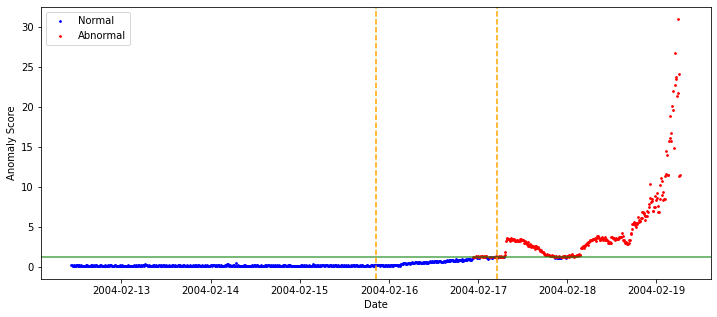

In [47]:
# 전체 데이터의 anomaly score 확인
draw_plot(ae_scores, ae_best_threshold)

In [48]:
# F1 Score: 0.9526
frr, far, f1, auroc, ie = calculate_metric(y_test, ae_best_threshold < ae_test)

print("**  FRR: {}  |  FAR: {}  |  F1 Score: {}  |  AUROC: {}  |  IE: {}"
      .format(round(frr, 4), round(far, 4), round(f1, 4), round(auroc, 4), round(ie, 4)))

**  FRR: 0.1  |  FAR: 0.0284  |  F1 Score: 0.9526  |  AUROC: 0.9358  |  IE: 0.0642


---